# Overview: Advanced Python

This lesson introduces Python as an environment for reproducible scientific data analysis and programming. Some of the lesson material are based on the Software Carpentry [Programming with Python lesson](http://swcarpentry.github.io/python-novice-inflammation/).

## License

As with [the Software Carpentry lesson](http://swcarpentry.github.io/python-novice-inflammation/license/), this lesson is licensed for open use under the [CC BY 4.0 license](https://creativecommons.org/licenses/by/4.0/).

### Contents

- **Capstone: Fitting Linear Models**
  - About the Data
  - Introducing `statsmodels`
- **Python at the Command Line**
  - Our First Python Script
  - Alternative Command-Line Tools
  - Modularization
- **Understanding and Handling Errors**
- **Defensive Programming**
  - Assertions
  - Test-Driven Development
  - Testing for Quality Control
  - Unit Testing
- **Analyzing and Optimizing Performance**
  - Benchmarking
- **Capstone: WHOI Data**
  - Your Tasks
  - Getting Started
- **Connecting to SQLite with Python**

# Capstone: Fitting Linear Models

We've seen the basics of the Python programming language. Now, let's get some hands-on experience applying what we've learned to real scientific data. **In this exercise, we'll see how to fit linear trends to data using a new Python library, `statsmodels`. After you see an initial example, you'll have time to extend the example on your own.**

# About the Data

The data we're using for this lesson are **monthly averages of surface air temperatures** from 1948 to 2016 for five different locations. They are derived from the NOAA NCEP CPC Monthly Global Surface Air Temperature Data Set, which has a 0.5 degree spatial resolution.

**What is the unit for air temperature used in this dataset?** Recall that when we assign a value to a variable, we don't see any output on the screen. To see our Barrow temperature data, we can use the `print()` function again.

In [2]:
import numpy as np
barrow = np.loadtxt('barrow.temperature.csv', delimiter = ',')
print(barrow)

[[ 245.66    247.52    245.28    256.32    262.9     272.46    278.06
   275.51    269.34    261.68    251.35    242.52  ]
 [ 248.12    242.64    252.04    248.61    262.84    271.93    277.45
   278.92    274.4     266.77    258.69    248.2   ]
 [ 252.3     240.39    248.66    255.41    265.84    274.64    278.87
   278.26    273.36    265.77    261.22    248.8   ]
 [ 239.52    242.16    243.65    256.21    266.      274.64    279.66
   279.17    273.23    264.89    260.47    249.39  ]
 [ 244.95    241.02    244.75    251.51    262.25    272.85    278.78
   277.02    270.84    264.87    259.14    248.89  ]
 [ 244.04    242.96    245.17    255.92    265.94    275.58    277.5     275.5
   272.59    261.36    254.54    245.16  ]
 [ 245.15    241.35    249.29    255.02    264.12    273.83    277.92
   279.6     273.92    266.54    256.88    244.83  ]
 [ 248.89    240.27    245.6     253.41    264.44    272.96    277.09
   274.26    271.2     260.74    248.42    246.11  ]
 [ 244.43    240.

The data are formatted such that:

- Each column is the monthly mean, January (1) through December (12)
- Each row is a year, starting from January 1948 (1) through December 2016 (69)

[More information on the data can be found here.](http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GHCN_CAMS/.gridded/.deg0p5/.temp/)

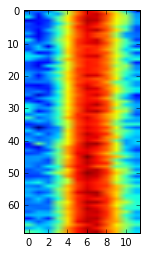

In [3]:
import matplotlib.pyplot as pyplot
%matplotlib inline

image = pyplot.imshow(barrow, aspect = 1/3)
pyplot.show()

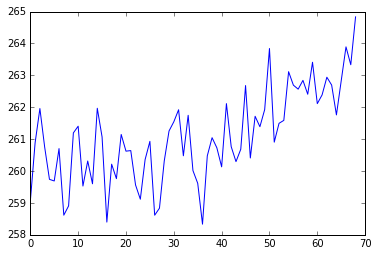

In [4]:
avg_temp = barrow.mean(axis = 1)
avg_temp_plot = pyplot.plot(avg_temp)
pyplot.show()

## Introducing `statsmodels`

Let's say we're interested in *temperature anomalies;* that is, the year-to-year deviation in temperature from a long-term mean.

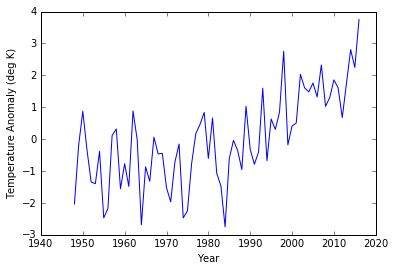

In [20]:
# Subtract the location's long-term mean
barrow_anomalies = barrow.mean(axis = 1) - barrow.mean()

pyplot.plot(range(1948, 2017), barrow_anomalies)
pyplot.xlabel('Year')
pyplot.ylabel('Temperature Anomaly (deg K)')
pyplot.show()

Neat! I can do more to make my plot look even nicer, however.

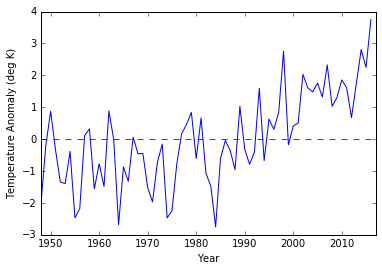

In [21]:
pyplot.plot(range(1948, 2017), barrow_anomalies)

# Show only this x-axis range
pyplot.xlim(1948, 2017)

# Create a red dashed line centered on 0 (y-axis) from 1948 to 2017
pyplot.hlines(0, 1948, 2017, colors = 'red', linestyles = 'dashed')

pyplot.xlabel('Year')
pyplot.ylabel('Temperature Anomaly (deg K)')
pyplot.show()

Let's also say we want to fit a straight line to the anomalies. **We can use the Python library `statsmodels` to fit an ordinary-least squares (OLS) regression to our temperature anomaly.**

In [27]:
import statsmodels.api as sm

data = np.loadtxt('barrow.temperature.csv', delimiter = ',')

# Subtract the location's long-term mean
y_data = data.mean(axis = 1) - data.mean()

# Create an array of numbers 1948, 1949, ..., 2016
x_data = np.arange(1948, 2017)
x_data

array([1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958,
       1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016])

`statsmodels` has a relatively "low-level" interface for calculating linear regression models; it makes us do a little work to get the answer. To use the ordinary least squares (OLS) regression tool in `statsmodels`, we also need to understand just a little bit about the math behind OLS regression.

Without going into too much detail, our linear trend line has two components: a constant term ($\alpha$) and the slope of the trend line ($\beta$). Using linear algebra, we represent these two terms as two columns in a matrix. **To fit a linear model with a constant term, the first column is a column of ones.**

$$
\begin{align}
[\mathrm{Temp.\ anomaly}]&=[\mathrm{Some\ constant,\ }\alpha] + [\mathrm{Slope\ of\ trend\ line},\beta]\times[\mathrm{Year}]\\
\left[\begin{array}{r}
-2.04\\
-0.20\\
0.88\\
\vdots\\
\end{array}\right] &= 
\left[\begin{array}{rr}
1 & 1948\\
1 & 1949\\
1 & 1950\\
\vdots & \vdots\\
\end{array}\right]
\left[\begin{array}{r}
\alpha\\
\beta\end{array}\right]
\end{align}
$$

In [32]:
# Add a constant (the intercept term)
x_data = sm.add_constant(x_data)
x_data[0:10,:] # Just show the first 10 rows

array([[  1.00000000e+00,   1.94800000e+03],
       [  1.00000000e+00,   1.94900000e+03],
       [  1.00000000e+00,   1.95000000e+03],
       [  1.00000000e+00,   1.95100000e+03],
       [  1.00000000e+00,   1.95200000e+03],
       [  1.00000000e+00,   1.95300000e+03],
       [  1.00000000e+00,   1.95400000e+03],
       [  1.00000000e+00,   1.95500000e+03],
       [  1.00000000e+00,   1.95600000e+03],
       [  1.00000000e+00,   1.95700000e+03]])

In [33]:
# Fit the temperature anomalies to a simple time series
results = sm.OLS(y_data, x_data).fit()
results

In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     58.47
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.04e-10
Time:                        08:55:34   Log-Likelihood:                -100.99
No. Observations:                  69   AIC:                             206.0
Df Residuals:                      67   BIC:                             210.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -97.2124     12.714     -7.646      0.000      -122.590   -71.835
x1             0.0490      0.006      7.647      0.000         0.036     0.062
==============================================================================
Omnibus:                        0.130   Durbin-Watson:                   1.442
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.111
Skew:                          -0.085   Prob(JB):                        0.946
Kurtosis:                       2.901   Cond. No.                     1.97e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
results.params

array([ -9.72123942e+01,   4.90476257e-02])

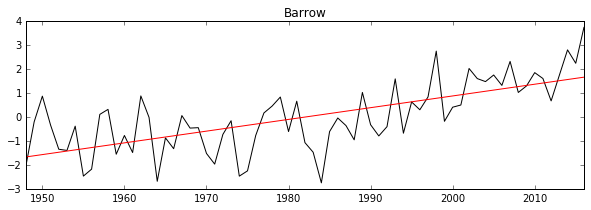

In [24]:
b0, b1 = results.params

# Calculate a line of best fit
fit_line = b0 + (b1 * x_data[:,1])

fig = pyplot.figure(figsize = (10.0, 3.0))
axis1 = fig.add_subplot(1, 1, 1)
axis1.plot(x_data, y_data, 'k')
axis1.plot(x_data, fit_line, 'r')
axis1.set_xlim(1948, 2016)
axis1.set_title('Barrow')
pyplot.show()

**What if we wanted to detect the direction of this fit line automatically?** It could be tedious to have a human being tally up how many are trending upwards versus downwards... Let's have the computer do it.

## Challenge: Fitting a Line over Multiple File Datasets

**Write a `for` loop, with an `if` statement inside, that calculates a line of best fit for each dataset's temperature anomalies and prints out a message as to whether that trend line is positive or negative.**

Hint: What we want to know about each trend line is whether, for:

```py
results = sm.OLS(y_data, x_data).fit()
b0, b1 = results.params
```

If `b1`, the slope of the line, is positive or negative. **So, to break that down:**

1. Loop over all the temperature files;
2. Calculate the temperature anomaly;
3. Fit an OLS regression to the anomaly data;
4. `print()` out whether the trend line is "positive" or "negative;"

### Hint: Looping over Files

In [36]:
import glob

filenames = glob.glob('*.csv')
filenames

['barrow.temperature.csv',
 'reston.temperature.csv',
 'land_o_lakes.temperature.csv',
 'key_west.temperature.csv',
 'wvu.temperature.csv']

### One Solution

In [26]:
import glob

filenames = glob.glob('*.csv')

# I can do these things outside of the loop
#  because the X data are the same for each dataset
x_data = np.arange(1948, 2017)
x_data = sm.add_constant(x_data) # Add the intercept term)

for fname in filenames:
    data = np.loadtxt(fname, delimiter = ',')
    
    # Subtract the location's long-term mean
    y_data = data.mean(axis = 1) - data.mean()

    # Fit the temperature anomalies to a simple time series
    results = sm.OLS(y_data, x_data).fit()
    
    b0, b1 = results.params

    if b1 > 0:
        print(fname, '-- Long-term trend is positive')
        
    else:
        print(fname, '-- Long-term trend is negative')

barrow.temperature.csv -- Long-term trend is positive
reston.temperature.csv -- Long-term trend is positive
land_o_lakes.temperature.csv -- Long-term trend is positive
key_west.temperature.csv -- Long-term trend is positive
wvu.temperature.csv -- Long-term trend is positive


# Python at the Command Line

We've seen a lot of tools and techniques for improving our productivity through reproducible Python code. So far, however, we've been working exclusively within Jupyter Notebook. Jupyter Notebook is great for interactive, exploratory work in Python and encourages literate programming, as we discussed earlier. A Notebook is a great place to demonstrate to your future self or your peers how some Python code works.

But when it's time to scale-up your work and process data, you want to be on the command line, for all the reasons we saw when we discussed the Unix shell earlier.

Let's explore Python programs at the command line using the following *Python script,* `temp_extremes.py`.

```py
'''
Reports the min and max July temperatures for each file
that matches the given filename pattern.
'''

import csv
import os
import sys
import glob

def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')

    for filename in glob.glob(filename_pattern):
        july_temps = []

        # While the file is open...
        with open(filename, 'r') as stream:
            # Use a function to read the file
            reader = csv.reader(stream)

            # Each row is a year
            for row in reader:
                # Add this year's July temperature to the list
                july_temps.append(row[6])

        # A human-readable name for the file        
        pretty_name = os.path.basename(filename)
        print(pretty_name, '--Hottest July mean temp. was', max(july_temps), 'deg K')
        print(pretty_name, '--Coolest July mean temp. was', min(july_temps), 'deg K')
        
        
if __name__ == '__main__':
    main()
```

We can run this script on the command line by typing the following:

```sh
$ python3 temp_extremes.py .
```

Remember that the single dot, `.` represents the current working directory, which is where all of our temperature CSV files are located.

## Our First Python Script

**Let's investigate this command-line program, line-by-line. We'll start to write this in our own text editor, calling the file `myscript.py` for now.**

**The docstring.** Every Python scripts, in fact any `*.py` file, ought to have a docstring at the top. The Python interpreter will accept a stand-alone, literal string at the top of the file without breaking your code; it is basically ignored, like a comment. As a multi-line string, we can type as many lines of text as we want in order to fully describe the purpose of the Python script.

```py
'''
Reports the min and max July temperatures for each file
that matches the given filename pattern.
'''
```

**Module imports.** The next few lines are where we import any necessary modules or objects from other Python files. These `import` statements should always be at the top of the script, as we see here. That way, we can tell at a glance what modules need to be installed in order to run this script.

```py
import os
import sys
import glob
```

**Now for the business part of our script. We first want to get the name of the directory where our program should look for temperature CSV files to process.**

How can a Python script take an argument from the command line? Recall how we can use the `print()` function to print things to the command line.

```py
print('Python version:', sys.version)
```

The `sys` module has an attribute `argv`, which stands for "argument variables." Whenever Python runs a program, it takes all of the values given on the command line and puts them in the list `sys.argv` so that the program can determine what they were.

```py
print('sys.argv is:', sys.argv)
```

If we run this program with no arguments, we see that the first item in the list is simply the name of the Python script that was executed:

```sh
$ python myscript.py
```

Try calling this script with multiple, different, made-up command-line arguments, e.g.:

```sh
$ python myscript.py first second third
```

**So, how can we use this to get the name of the directory we need?**

```py
# Get the user-specified directory
directory = sys.argv[1]
files = os.listdir(directory)
print(files)
```

**Next, we want to search this directory's files for temperature CSV files.** We can use the `glob` module to search for files that match GLOB regular expressions, the same file-matching patterns that we used in the Unix shell lesson.

We use the `os.path` module's `join()` function to concatenate strings that represent file paths. We could use simple string concatenaion here, but the `join()` function has some additional business logic that checks to make sure we end up with a valid file path, so it's best to use this function always for this purpose.

```py
# Pattern to use in searching for files
filename_pattern = os.path.join(directory, '*temperature.csv')
files = glob.glob(filename_pattern)
print(files)
```

### Encapsulating to Keep the Namespace Clean

What do we have so far?

```py
import os
import sys
import glob

# Get the user-specified directory
directory = sys.argv[1]

# Pattern to use in searching for files
filename_pattern = os.path.join(directory, '*temperature.csv')
files = glob.glob(filename_pattern)
print(files)
```

This works great but could benefit from some Python best practices. First, we need to observe that every Python script is itself a module to be imported into Python. We can demonstrate this by starting an interactive session:

```sh
$ python3
```

And then:

```py
>>> import myscript
```

We get an error, but it's only because we are trying to index the `sys.argv` list's second element and it only has one element total (because we didn't call this script from the command line). If we change `sys.argv[1]` to a dot '.' and run it again...

```py
>>> import myscript
```

Note that everything in the script we wrote was executed in this session! Even the `print()` function was executed and its output displayed here.

**Can you see how this could be problematic?** To avoid this problem, we need to distinguish between objects in our *namespace* that we want to make available to other Python programs and those we want to keep private. In general, if our Python script has one principal purpose, we should create a Python function that fulfills that purpose and hide all the "sausage-making" details within.

```py
import os
import sys
import glob

def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')
    files = glob.glob(filename_pattern)
    print(files)
```

Now let's run this script again.

```sh
$ python3 myscript.py .
```

**What happened?** Nothing. Why? This script merely defines a function, `main()`. There is no place where that function is called.

Python has a special syntax that we use in a script for determining when the script is called from the command line.

```py
if __name__ == '__main__':
    main()
```

**Why does this work? Let's enter an interactive session again.**

In [120]:
__name__

'__main__'

In [121]:
import os
os.__name__

'os'

**Note that aliasing a library doesn't change it's `__name__`; it's `__name__` is derived from the filename.**

In [122]:
import os as something
something.__name__

'os'

So, `__name__` is a special attribute of a module, including the *global environment,* that identifies it. When we execute code in a Python session, rather than as part of a module, it gets the special name `'__main__'`.

### Finishing our First Script

What do we have so far?

```py
import os
import sys
import glob

def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')
    files = glob.glob(filename_pattern)
    print(files)
    

if __name__ == '__main__':
    main()
```

No we need to loop over each file and do something useful with it. **Let's start a `for` loop iterating over the `files` we matched.**

```py
def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')
    
    for filename in glob.glob(filename_pattern):
        july_temps = [] # List to hold July temperatures
```

Next, we'll open the file. A good way to open a file in Python is using the `with` statement to create a *context;* a *context* in Python is an environment within which certain variables are available. Outside of that context, those variables can't be accessed. **The advantage of opening a file in a context is that it is automatically closed when we exit that context; it also makes a code more readable.**

```py
def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')

    for filename in glob.glob(filename_pattern):
        july_temps = [] # List to hold July temperatures
        
        # Open the file in "r" for "reading" mode
        with open(filename, 'r') as stream:
            print(type(stream))
```

Every file input-output (I/O) object in Python has a `read()` method. We can use that to read the contents of a file.

```py
def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')

    for filename in glob.glob(filename_pattern):
        july_temps = [] # List to hold July temperatures

        # Open the file in "r" for "reading" mode
        with open(filename, 'r') as stream:
            stream.read()
```

That's a lot of output! It reads the entire file out. **We need a way of managing the output from each file. Specifically, we need a special kind of "Reader" that understands the output from a CSV file.**

First, let's add a new module import; we want to read from CSV files, so we need the `csv` module.

```py
import csv
```

Next, we'll use this module to more effectively read from our CSV files.

```py
def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')

    for filename in glob.glob(filename_pattern):
        july_temps = [] # List to hold July temperatures

        # Open the file in "r" for "reading" mode
        with open(filename, 'r') as stream:
            # Create a special Reader that understands CSV files
            reader = csv.reader(stream)
            
            # Each row is a year
            for row in reader:
                # Add this year's July temperature to the list
                july_temps.append(row[6])
```

Finally, we're ready to use the July temperature list we accumulated for each file.

```py
def main():
    # Get the user-specified directory
    directory = sys.argv[1]

    # Pattern to use in searching for files
    filename_pattern = os.path.join(directory, '*temperature.csv')

    for filename in glob.glob(filename_pattern):
        july_temps = []

        # Open the file in "r" for "reading" mode
        with open(filename, 'r') as stream:
            # Create a special Reader that understands CSV files
            reader = csv.reader(stream)

            # Each row is a year
            for row in reader:
                # Add this year's July temperature to the list
                july_temps.append(row[6])

        # A human-readable name for the file        
        pretty_name = os.path.basename(filename)
        print(pretty_name, '--Hottest July mean temp. was', max(july_temps), 'deg K')
        print(pretty_name, '--Coolest July mean temp. was', min(july_temps), 'deg K')
```

## Alternative Command-Line Tools

`sys.argv` is a rather crude tool for processing command-line arguments. There are a couple of alternatives I suggest you look into if you are going to be writing command-line programs in Python:

- `argparse`, another built-in library, that handles common cases in a systematic way. Check out [this tutorial](http://docs.python.org/dev/howto/argparse.html).
- `Fire`, [a very new Python module from Google](https://opensource.googleblog.com/2017/03/python-fire-command-line.html), which can turn any Python object (function, class, etc.) into a command-line API.

### Optional: Try out Python Fire

[Installation instructions and source code here.](https://github.com/google/python-fire)

## Modularization

As I indicated earlier, any Python script can be imported like a module. You may have noticed that, as some Python libraries get very large, it's helpful to have *submodules.* For instance, we've seen:

```py
import matplotlib.pyplot as pyplot
import statsmodels.api as sm
```

At some point you may want to organize all of your related Python code as a module, but you may still want to keep separate Python scripts. A good model for organizing your code is:

```
package_name/
    __init__.py
    module1.py
    subpackage/
        __init__.py
        module2.py
```

Which could be used as:

```py
import package_name.module1
from package_name.module1 import some_function
from package_name.subpackage import module2
from package_name.subpackage.module2 import another_function
```

In these examples, a text file titled `__init__.py` is *required* in each directory. This file, which could be blank, indicates to the Python intepreter that the directory containing it should be considered as a Python module.

### Installing Your Project as a Module

We haven't covered installing new Python modules, but when the time is right for you to package your code together as a single module (e.g., as `package_name`, in the example above), [consider installing your module "in development mode" first.](https://packaging.python.org/tutorials/distributing-packages/#working-in-development-mode)

# Understanding and Handling Errors

Every programmer encounters errors;

- Both those who are just beginning,
- And those who have been programming for years.

Encountering errors and exceptions can be very frustrating at times, and can make coding feel like a hopeless endeavour. However, understanding what the different types of errors are and when you are likely to encounter them can help a lot. Once you know why you get certain types of errors, they become much easier to fix.

Errors in Python have a very specific form, called a **traceback.** Let’s examine one:

In [123]:
import statsmodels.api as sm

def calc_best_fit_line(y_data, x_data = np.arange(1948, 2016)):
    '''
    Calculates a line of best fit through the `y_data` based
    on the provided `x_data`.
    '''

    # Add a constant (the intercept term)
    x_data = sm.add_constant(x_data)

    # Fit the temperature anomalies to a simple time series
    results = sm.OLS(y_data, x_data).fit()
    
    return results.params


# Load the data
data = np.loadtxt('wvu.temperature.csv', delimiter = ',')

calc_best_fit_line(temperature_anomaly(data))

ValueError: endog and exog matrices are different sizes

**This is really long! And intimidating, at first. Let's break it down.**

- You can see there are multiple groups in this traceback; each is associated with a different Python file. These are the Python files that have code that was run as part of the code we executed. **It's important to realize that most Python programs depend on a lot of other Python code! This is why we're able to do such complex things so quickly in Python--because a lot of the foundational work has already been done.** However, this also means that tracebacks can get quite long.
- In the first line of the traceback, Python tells us the type of error (a `ValueError`) and it reminds us that the "most recent call [is listed] last." This means that the traceback is sorted in the order by which Python functions were called. Each time a Python function calls another Python function, we get a new line in the traceback.
- Because the "most recent call [is listed] last," we can see the code that we just wrote at the top, displayed first. **The arrow shows the specific line that started the cascade of functions that led to the error.**
- In the last line of the traceback, Python helpfully tells us the category or type of error (in this case, it is an `ValueError`) and a more detailed error message (`'endog and exog matrices are different sizes'`).

**To debug this error:** 

- We have to first understand the error message. 
- We know `statsmodels` is involved, because that's the codebase that the last line of the traceback is in (according to the filename).
- The second line of the traceback shows our call to the `sm.OLS()` function. We might include the name of the `OLS` function in an online search, along with the error message itself.

Ultimately, we have to know that `endog` and `exog` are the names of arguments to the `OLS()` function in `statsmodels`. As it turns out, the array we specified for the `x_data` argument in our new function is not the right size. We need to provide `np.arange(1948, 2017)`; recall that in `np.arange()`, the range goes *up to but not including* the second number.

# Defensive Programming

Up to this point, we've introduced the basic tools of programming:

- Variables and lists,
- File input and output,
- Loops,
- Conditionals, and
- Functions.

**But how can we tell whether a program is giving us the right answer? How can we tell if it's *still* giving us the right answer after we've made changes to it?**

To achieve that, we need to:

- Write programs that check their own operation;
- Write and run tests for widely-used functions;
- And make sure we know what "correct" actually means.

The good news is that doing all of these things will actually improve our productivity, not slow us down.

## Assertions

The first step toward getting the right answers from our programs is to assume that mistakes *will* happen and to guard against them. This is called **defensive programming,** and the most common way to do it is to add **assertions** to our code so that it checks itself as it runs.

For example, let's suppose that one of the first things we do when we acquire new temperature data is to produce a series of temperature anomaly plots.

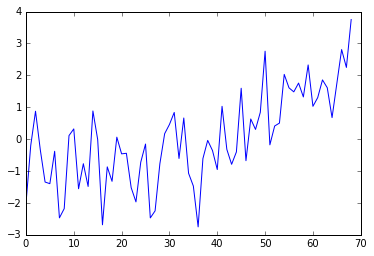

In [124]:
import matplotlib.pyplot as pyplot
%matplotlib inline

data = np.loadtxt('./barrow.temperature.csv', delimiter = ',')

def plot_temperature_anomaly(temp_array):
    pyplot.plot(temp_array.mean(axis = 1) - temp_array.mean())
    pyplot.show()
    
plot_temperature_anomaly(data)

**Because we're going to compare these temperature anomaly plots to others we've made in the past, using the same function, we expect the temperature data to be in a certain format and with certain units of measure.**

What if someone provided data that were not in the correct units, e.g., degrees F instead of degrees C?

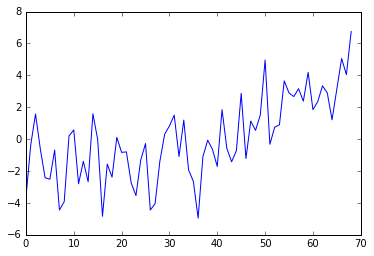

In [125]:
plot_temperature_anomaly(kelvin_to_fahr(data))

Our temperature anomaly plot has the same shape but the numbers are very different; it looks like the anomalies are more extreme than they really are.

**We'd like to add a test to our plotting function to ensure against data with the wrong units being provided.**
The `np.all()` function is a useful function that returns `True` *only* if all the elements of an array are True.

In [126]:
data_in_f = kelvin_to_fahr(data)

# Are all values greater than zero?
np.all(data_in_f > 0)

False

This is a good test for regions that experience freezing temperatures, but regions that never experience such temperatures would still pass this test when the units are in Fahrenheit. We may have to add additional tests to absolutely guard against temperature data in the wrong units, but this is a good start.

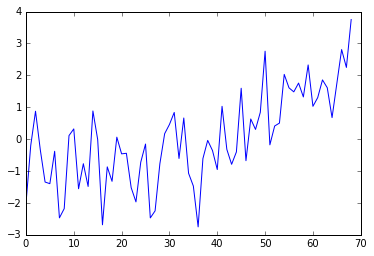

In [127]:
def plot_temperature_anomaly(temp_array):
    assert np.all(temp_array > 0), 'Temperature values (in degrees Kelvin) should be greater than zero'
    pyplot.plot(temp_array.mean(axis = 1) - temp_array.mean())
    pyplot.show()
    
plot_temperature_anomaly(data)

In [128]:
plot_temperature_anomaly(kelvin_to_fahr(data))

AssertionError: Temperature values (in degrees Kelvin) should be greater than zero

Most software programs that you use are full of assertions. In the Firefox web browser, for instance, among versions, 10-20% of the code is there to check that the other 80-90% is working correctly.

Broadly speaking, assertions fall into three categories:

- A *precondition* is something that must be true at the start of the function in order for it to work correctly.
- A *postcondition* is something that the function guarantees is true when it finishes.
- An *invariant* is something that is always true at a particular point inside a piece of code.

Assertions can be thought of as quality control or quality assurance for software. **Can you think of examples from your work where you would benefit from preconditions, postconditions, or invariants?**

Most people who develop software fail to follow two rules when adding assertions to their code: 

- **Fail early, fail often:** The more time that elapses between when an error occurs and when it is first noticed, the greater the potential damage (e.g., to your analysis, to the outputs of your software) and the harder it will be to debug (because the software has grown to be more complicated and interdependent). Good code catches mistakes as early as possible.
- **Turn bugs into assertions or tests:** Whenever you fix a bug, write an assertion that catches the mistake should you make it again. The odds are good that you have made similar mistakes nearby or will make the same or a similar mistake the next time you change this part of this code.

### Assertations Regarding Type (Advanced)

When we were creating functions for re-use, we often required one or more function arguments; inputs to the function that were used in the logic of the function body. We made assumptions about what kind of Python object a user provided for each argument. Recall our working example below.

In [129]:
def plot_temperature_anomaly(temp_array):
    pyplot.plot(temp_array.mean(axis = 1) - temp_array.mean())
    pyplot.show()

Here, we assume that the `temp_array` argument is a NumPy array. After all, we need to be able to call the `mean()` method on whatever object receives the `temp_array` name when the function is executed.

In [130]:
plot_temperature_anomaly([0.5, 1.0, 1.5])

AttributeError: 'list' object has no attribute 'mean'

When we provide the wrong kind of argument to this function, a `list` instead of a NumPy array, the Python interpreter attempts to call the `mean()` method on a `list`. However, a `list` has no method called `mean()`, and so our code breaks.

**How can we guard against this type of user error, particularly if we suspect the users of our code will not understand the `AttributeError` above?** In Python, we have functions to check the *type* or class of an object; we can combine this with the `assert` statement that we've already seen.

In [131]:
a_list = [0.5, 1.0, 1.5]
type(a_list)

list

In [132]:
a_string = 'a string'
type(a_string)

str

How does the `type()` function work?

In [133]:
type(a_string) == str

True

How can we use the `type()` function to guard against a user providing the wrong kind of object?

In [134]:
type(data)

numpy.ndarray

Recall that we imported the `numpy` library with the alias `np` using:
```py
import numpy as np
```

Consequently, when we check for type, we can use either the alias or the original name.

In [135]:
type(data) == np.ndarray == numpy.ndarray

True

In [136]:
def plot_temperature_anomaly(temp_array):
    assert type(temp_array) == numpy.ndarray, 'Expected temp_array to be a numpy.ndarray'
    pyplot.plot(temp_array.mean(axis = 1) - temp_array.mean())
    pyplot.show()
    
plot_temperature_anomaly([0.5, 1.0, 1.5])

AssertionError: Expected temp_array to be a numpy.ndarray

### Challenge: Asserting Type in a Function

Recall the `celsius_to_fahr()` function we saw earlier. Implement a type-checking assertion that produces an `AssertionError` when the `temp_c` argument is not a number. Remember that there are two types of numbers we've see in Python so far:

- `float`
- `int`

You can decide whether the `celsius_to_fahr()` function should accept one or both of these types as inputs. **Don't forget to provide a helpful message as part of the `AssertionError`.**

In [137]:
def celsius_to_fahr(temp_c):
    return (temp_c * (9/5)) + 32

### Assertions Regarding Inherited Type (Advanced)

Assertions on the `type` of an object are extremely useful when we want to test that a particular Python object is a specific type. However, there are many situations where testing the `type` of an object is not ideal.

We won't go into too much detail regarding Python classes, subclasses, and inheritance. **Suffice to say, in Python, some kinds of objects are very similar to other kinds of objects but have distinct types.**

As a quick toy example, suppose that we have a simple function that reports on the *metadata* related to our temperature data.

In [138]:
my_metadata = {'date': '2018-05-10', 'units': 'Celsius'}
def check_metadata(metadata):
    assert type(metadata) == dict, 'Expected a Python dictionary'
    print(list(metadata.keys()))

In [139]:
check_metadata(my_metadata)

['units', 'date']


This function takes a Python dictionary, or `dict`, which, as we've discussed, is a way of representing key-value pairs. Recall that Python dictionaries are inherently unordered: the key-value pairs have no intrinsic ordering. However, there is a similar built-in data type, called an ordered dictionary, or `OrderedDict`, which does allow the key-value pairs to maintain an order.

In [140]:
from collections import OrderedDict
OrderedDict(my_metadata)

OrderedDict([('units', 'Celsius'), ('date', '2018-05-10')])

In [141]:
my_ordered_metadata = OrderedDict(my_metadata)
my_ordered_metadata.keys()

odict_keys(['units', 'date'])

**What if we used `OrderedDict` to represent our metadata?**

In [142]:
check_metadata(my_ordered_metadata)

AssertionError: Expected a Python dictionary

Our assertion is working just as we expected. `OrderedDict` has a different `type` from the regular `dict` type.

In [143]:
type(my_ordered_metadata)

collections.OrderedDict

But an `OrderedDict` isn't all that different from a `dict`. They both store key-value pairs. Can't we re-write this assertion so that our function accepts both `dict` and `OrderedDict` types?

**There is another way to check the *class* of an object in Python that acknowledges that some Python objects are descended from others.** Again, we won't go into too much detail about this, but it turns out that the `OrderedDict` class is descended from, or *inherits* from the `dict` class. They both have a `keys()` method, which is all that really matters for the purposes of our `check_metadata()` function. 

In [144]:
isinstance(my_metadata, dict)

True

In [145]:
isinstance(my_ordered_metadata, dict)

True

In [146]:
def check_metadata(metadata):
    assert isinstance(metadata, dict), 'Expected something like a Python dictionary'
    print(list(metadata.keys()))
    
check_metadata(my_ordered_metadata)

['units', 'date']


### Duck Typing (Advanced)

We've seen two ways of verifying the type or class of an object in Python.

- `type()`
- `isinstance()`

The major limitation with both of these approaches, however, is that they don't actually verify what we're most interested in: whether or not the Python object in question has the *attributes* we really care about.

- In the temperature anomaly example, we didn't really care that the user's input was a NumPy array; we just wanted  something that holds a series of values and possesses a `mean()` method.
- In the `check_metadata()` example, we didn't really care whether the user's input was a `dict` or an `OrderedDict`; we just wanted something that holds key-values pairs and possess a `keys()` method.

Today, most software engineers argue that, instead of testing the `type` or `class` of an object, you should test that an object has the properties you are interested in. **This approach is called *duck typing,* as in the old maxim:**

> If it looks like a duck, swims like a duck, and quacks like a duck, then it probably is a duck.

That is, if we want to test whether a Python object is a duck, we shouldn't bother with:

```py
type(maybe_duck, duck)
isinstance(maybe_duck, duck)
```

Instead, we should test whether duck looks, swims, or quacks like a duck.

In [147]:
hasattr(data, 'mean')

True

In [148]:
def plot_temperature_anomaly(temp_array):
    assert hasattr(temp_array, 'mean'), 'Expected temp_array to have a mean() method, like numpy.ndarray'
    pyplot.plot(temp_array.mean(axis = 1) - temp_array.mean())
    pyplot.show()
    
plot_temperature_anomaly([0.5, 1.0, 1.5])

AssertionError: Expected temp_array to have a mean() method, like numpy.ndarray

**For more information about types, classes, and how Python represents objects, see:**

- [Python 3 Documentation: The Python Data Model](https://docs.python.org/3/reference/datamodel.html#)

## Test-Driven Development

An assertion checks that something is true at a particular point in the program. The next step is to check the overall behavior or a piece of code, i.e., to make sure that it produces the right output when it's given a particular input.

For example, suppose we need to find where two or more time series overlap. The range of each time series is represented as a pair of numbers, which are the time the interval started and ended. The output is the largest range that they all include.

![](./python-overlapping-ranges.svg)

**Most novice programmers would solve the problem like this:**

1. Write a function called `range_overlap()`;
2. Call it interactively on two or three different inputs;
3. If it produces the wrong answer, fix the function and re-run that test.

This clearly works, but there's a better way:

1. Write a short function for each test that your solution should satisfy if it were to work;
2. Write a `range_overlap()` function that should pass those tests;
3. If `range_overlap()` produces any wrong answers, fix it and re-run the test functions.

**Writing the tests *before* writing the function they exercise is called test-driven development.**

Here are three test functions for `range_overlap()`.

```py
assert range_overlap([ (0.0, 1.0) ]) == (0.0, 1.0)
assert range_overlap([ (2.0, 3.0), (2.0, 4.0) ]) == (2.0, 3.0)
assert range_overlap([ (0.0, 1.0), (0.0, 2.0), (-1.0, 1.0) ]) == (0.0, 1.0)
```

As part of writing these tests, we've implicitly defined what our input and output look like: we expect a list of pairs as input and produce a single pair as output.

We're missing a test case, however; what should happen when the ranges don't overlap at all? Or if they share a boundary?

```py
assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == ???
assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == ???
```

What should `range_overlap()` do in the first case? Fail with an error message? Return a special value?

And in the second case... Does the pair of ranges overlap? Mathematicians would generally say "yes," while engineers would generally say "no."

Any actual implementation of the function will come down on one side or the other of these issues; writing the test *first* helps us figure out which is best *before* we're invested in whatever we happened to write before we realized there was an issue.

**Since we're planning to use the `range_overlap()` function to generate a time series for the horizontal axis in a plot, we'll decide:**

- Every overlap has to have non-zero width, and,
- We will return the special value `None` when there's no overlap.

`None` is built into Python and means "nothing here."

```py
assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == None
assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == None
```

### A Potential Solution

In [149]:
def range_overlap(ranges):
    '''Return common overlap among a set of [low, high] ranges.'''
    lowest = 0.0
    highest = 1.0
    for (low, high) in ranges:
        lowest = max(lowest, low)
        highest = min(highest, high)
        
    return (lowest, highest)

Let's see if this does the trick. We can write a single function that encompasses all of our tests to make development and future testing that much easier.

In [150]:
def test_range_overlap():
    assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == None
    assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == None
    assert range_overlap([ (0.0, 1.0) ]) == (0.0, 1.0)
    assert range_overlap([ (2.0, 3.0), (2.0, 4.0) ]) == (2.0, 3.0)
    assert range_overlap([ (0.0, 1.0), (0.0, 2.0), (-1.0, 1.0) ]) == (0.0, 1.0)
    
test_range_overlap()

AssertionError: 

**The first test was supposed to produce `None`, so we know that something is wrong with our function.** We *don't* know whether the other tests passed or failed because Python halted the program as soon as it spotted the first error.

It turns out that the problem is that we initialized `lowest` and `highest` to 0.0 and 1.0, respectively, regardless of the input values. **In general, we should always initialize from the data.**

There's another problem with our testing framework. When a test fails, we don't know why. We can add a message to any Python assertion that will provide some information about what was expected to happen but didn't.

In [151]:
def test_range_overlap():
    assert range_overlap([ (0.0, 1.0), (5.0, 6.0) ]) == None, 'Should return None for ranges that do not intersect'
    assert range_overlap([ (0.0, 1.0), (1.0, 2.0) ]) == None, 'Should return None for ranges that do not intersect'
    assert range_overlap([ (0.0, 1.0) ]) == (0.0, 1.0), 'Should return same input when single pair is provided'
    assert range_overlap([ (2.0, 3.0), (2.0, 4.0) ]) == (2.0, 3.0)
    assert range_overlap([ (0.0, 1.0), (0.0, 2.0), (-1.0, 1.0) ]) == (0.0, 1.0)
    
test_range_overlap()

AssertionError: Should return None for ranges that do not intersect

### Challenge: Fix the Range Overlap Function

Fix `range_overlap()`; re-run `test_range_overlap()` after each change you make.

In [152]:
def range_overlap(ranges):
    '''Return common overlap among a set of [low, high] ranges.'''
    for i, (low, high) in enumerate(ranges):
        if i == 0:
            lowest, highest = low, high
            continue
            
        lowest = max(lowest, low)
        highest = min(highest, high)
        
    if lowest >= highest:
        return None
        
    return (lowest, highest)

test_range_overlap()

## When in Doubt...

In [153]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


## Testing for Quality Control

In scientific computing in particular, testing is used not only to make sure our software continues to work in an expected way but to make sure that the scientific results we derive with our software are consistent and accurate. Often, we build scientific computing workflows to analyze large volumes of data, whether they are large text document collections, high-resolution images, or large genome datasets.

**How can we encode expected values into our tests for very large data without reproducing (and storing) excessively large files?** For instance, if we want to test code that takes an input gigabyte-scale file and transforms it into a similarly large file, how can we test that the function works correctly?

One approach is obviously to make a sample dataset that is very small but also representative. Another would be to procedurally generate synthetic data. However, if we have reference datasets that we want to run tests on, and we want to ensure that we get the same output every time, the easiest solution is to calculate a *checksum.*

**You may have encountered checksums before, say, as a means of verifying that a downloaded or decompressed file is uncorrupted.** A checksum is just a fancy mathematical function that takes in an arbitrarily long byte sequence and returns a short, *unique* alpha-numeric string.

As an example, consider our temperature data. We want to convert it from Kevlin to Celsius and test that the output file contains exactly what we expected.

In [154]:
data = np.loadtxt('./barrow.temperature.csv', delimiter = ',')

# Convert to Celsius
data_c = np.apply_along_axis(kelvin_to_celsius, 0, data)
data_c

array([[-27.49  , -25.63  , -27.87  , -16.83  , -10.25  ,  -0.69  ,
          4.91  ,   2.36  ,  -3.81  , -11.47  , -21.8   , -30.63  ],
       [-25.03  , -30.51  , -21.11  , -24.54  , -10.31  ,  -1.22  ,
          4.3   ,   5.77  ,   1.25  ,  -6.38  , -14.46  , -24.95  ],
       [-20.85  , -32.76  , -24.49  , -17.74  ,  -7.31  ,   1.49  ,
          5.72  ,   5.11  ,   0.21  ,  -7.38  , -11.93  , -24.35  ],
       [-33.63  , -30.99  , -29.5   , -16.94  ,  -7.15  ,   1.49  ,
          6.51  ,   6.02  ,   0.08  ,  -8.26  , -12.68  , -23.76  ],
       [-28.2   , -32.13  , -28.4   , -21.64  , -10.9   ,  -0.3   ,
          5.63  ,   3.87  ,  -2.31  ,  -8.28  , -14.01  , -24.26  ],
       [-29.11  , -30.19  , -27.98  , -17.23  ,  -7.21  ,   2.43  ,
          4.35  ,   2.35  ,  -0.56  , -11.79  , -18.61  , -27.99  ],
       [-28.    , -31.8   , -23.86  , -18.13  ,  -9.03  ,   0.68  ,
          4.77  ,   6.45  ,   0.77  ,  -6.61  , -16.27  , -28.32  ],
       [-24.26  , -32.88  , -27.55  , -19

We can save our converted array to a CSV file, similar to the one we read in.

In [155]:
np.savetxt('./barrow.temperature.Celsius.csv', data_c, delimiter = ',')

We can perform a checksum over the contents of this file using the built-in Python library of hash functions. **Recall that a checksum or hash function returns a unique string for any unique input byte sequence.**

In [156]:
import hashlib
hash_func = hashlib.sha256()

# We have to encode any text strings as bytes
hash_func.update(b'Some important scientific data')
hash_func.digest()

b'\xe4\xbcT;\xb4\xf8d}b\x1bX\x98,\x89\x87?\xeb\x19\xd5\x0e\xce\xa4\x9c\x9a\xf6\xfb\x8f\x8aT\x8b\xc6y'

Whenever we call `update()`, the effect is to concatenate the inputs. Thus, after an `update()`, the input has changed and we therefore expect the hexadecimal digest to be different.

In [157]:
hash_func.update(b'Some additional scientific data, different from before')
hash_func.digest()

b'A\xe3\x9f\xb9\xf4\xc4\xb9A\xda\x90D\xfdK\x8b\xc1~\xa5_F\xa0n\xac\xc7(7\x7f#t\x10\xa1\x07O'

**How can we use this to verify that a file is unchanged?** We can read the file in as a Python byte array and then hash it.

In [158]:
# Re-initialize our hash function to clear any prior inputs
hash_func = hashlib.sha256()

# Note that the mode must include 'b' for "binary"
file_stream = open('./barrow.temperature.Celsius.csv', mode = 'rb')
hash_func.update(file_stream.read())
hash_func.digest()

b'}\x00\x00U\xfb\xaf\xd2\xc6\x11\xbe\xc8Rl\x9b\xacd\xa4D9\x99"\xde\x02A\xf5dR\xdd\x94k\xaa\xf6'

Any time we use `open()` in Python, we need to make sure we close the connection to the file.

In [159]:
file_stream.close()

A more concise way of doing the same thing, while also testing that the file's contents match a certain checksum, is to use the Python `with` statement.

In [160]:
hash_func = hashlib.sha256()

with open('./barrow.temperature.Celsius.csv', mode = 'rb') as file_stream:
    hash_func.update(file_stream.read())
    
assert hash_func.digest() == b'}\x00\x00U\xfb\xaf\xd2\xc6\x11\xbe\xc8Rl\x9b\xacd\xa4D9\x99"\xde\x02A\xf5dR\xdd\x94k\xaa\xf6'

The Python `with` statement creates a *context,* a part of our code where certain variables are available for use:

- When a `with` context is used to `open()` a file, as in the above example, we use `as` to declare a variable. The variable in this case, `file_stream` is available throughout the code block that follows.
- Outside of the `with` context (outside of the code block), the `file_stream` variable is no longer available.
- When `with` is used to open a file, the file is also automatically closed after the `with` statement's code block is executed. This saves us the trouble of having to call `close()` on the `file_stream` object.

Now, if something changed about the file--for instance, if the file's contents were not converted from Kelvin to Celsius, we would detect it as a change in the checksum.

In [161]:
hash_func = hashlib.sha256()

with open('./barrow.temperature.csv', mode = 'rb') as file_stream:
    hash_func.update(file_stream.read())
    
assert hash_func.digest() == b'}\x00\x00U\xfb\xaf\xd2\xc6\x11\xbe\xc8Rl\x9b\xacd\xa4D9\x99"\xde\x02A\xf5dR\xdd\x94k\xaa\xf6'

AssertionError: 

## Unit Testing

**A good test is one that verifies that a *small* and *specific* part of your code is working.** If a test is written too generally, then we don't actually know went wrong when the test fails. In general, when we test a specific part of a larger code base, we are *unit testing.*

Python has a built-in unit testing module. Let's try it out.

```py
import unittest

class Main(unittest.TestCase):
    
    def test_range_overlap_with_disjoint_ranges(self):
        'Should return None for ranges that do not intersect'
        self.assertEqual(range_overlap([ (0.0, 1.0), (5.0, 6.0) ]), None)
        self.assertEqual(range_overlap([ (0.0, 1.0), (1.0, 2.0) ]), None)
        
    def test_range_overlap_with_single_range(self):
        'Should return same input when single range is provided'
        self.assertEqual(range_overlap([ (0.0, 1.0) ]), (0.0, 1.0))
        
        
if __name___ == '__main__':
    unittest.main()
```

# Analyzing and Optimizing Performance

This workshop on Python has largely been framed as offering a way to improve your productivity. If we are able to get the same job done faster by using Python and other computational tools to automate our workflow, we're definitely going to get the job done faster. But how does Python software typically compare to software written in other languages? How can we measure the performance of a Python program and think critically about its effects on our productivity?

Whenever we think about a new programming task and how to implement it, there are choices to be made, first and foremost as to which programming language to use. **We talked about *compiled* languages like C, C++, and Java earlier.** A software program written in a compiled language will almost always take less time to complete the same task than a program written in an interpreted language, like Python. There are several reasons for this, most beyond the scope of this discussion.

Importantly, however, we have to consider the differences between languages like C, C++, or Java and a language like Python. While compiled programs, once written, run faster, they take longer to write than a program in Python because Python offers higher-level tools and constructs for getting work done, automatically handling things like file input/ output, memory management, and data types. **Thus, it will almost always take you, the programmer, less time to create the equivalent program in Python than in other languages.** The time it takes to write has to be considered as part of the total "running time" of any task you're considering.

The time it takes to *re-write* any code should also be considered *before* attempting to change a program to make it run faster.

> "Premature optimization is the root of all evil." - Sir Tony Hoare (later popularized by Donald Knuth)

## Benchmarking

A software program can be *benchmarked* in many ways: the time it takes to finish a task, the average framerate during a video game's animation, or the total amount of memory required.


**An easy way to benchmark a Python program's *runtime,* is to use the Unix program `time`.**

```sh
$ time python3 myscript.py
```

The specific meaning of the three measurements provided are:

- "Real" time is the actual time elapsed, from start to finish.
- "User" time is the amount of **CPU time** spent outside of the kernel, during the Python process. This might include time Python spent doing other things, like garbage collection.
- "Sys" time is the amount of **CPU time** spent inside the kernel. Since there are certain things that the Python process is not allowed to do, but might be required to complete the task, like allocating more memory.

"Real" time might be long just because there are other programs running on your system and the Python process had to wait. If you add the "sys" and "user" times together, this gives you the amount of time your CPU(s) spent running that process regardless of other programs running. Also, if their sum is much less than the "real" time, it is likely that most of the program's performance issues are related to input-ouput ([according to Huy Nguyen](https://www.huyng.com/posts/python-performance-analysis)).

**Another easy benchmark for small bits of Python code is provided through Python's `timeit` module.**

```sh
$ python3 -m timeit -n 10000 -r 3 "[str(n) for n in range(100)]"
10000 loops, best of 3: 15.7 usec per loop

$ python3 -m timeit -n 10000 -r 3 "map(str, range(100))"
10000 loops, best of 3: 0.587 usec per loop
```

Here, the options:

- `-n` indicates the number of times the statement should be executed; an average of all runtimes is taken.
- `-r` indicates the number of times the suite should be repeated; for 3 times (the default), the statement is run (3 x N) times total, and the best mean time in each of the 3 suites is reported.

If you need to run some setup code that you don't want counted against the time, such as importing a module, you can use the `-s` option.

## Line and Memory Profiling

Line and memory profilers aren't available in the Anaconda installation I had you use, [but you can read all about this topic on this excellent blog post.](https://www.huyng.com/posts/python-performance-analysis)

# Capstone: WHOI Data

Now you have a chance to bring together everything you've learned in this Software Carpentry workshop, particularly:

- Using the Unix shell to download and manage delimited text data files;
- Importing data into Python;
- Using NumPy or other Python tools to summarize the data and diagnose any data issues;
- Cleaning and plotting the data using reproducible Python functions;

For this open-ended exercise, we'll use data from [the Woods Hole Oceanographic Institution's "Martha's Vineyard Coastal Observatory."](http://www.whoi.edu/page.do?pid=70177) **Choose which of the following datasets you want to work with:**

- [**The meteorological record**](http://www.whoi.edu/mvco/meteorological-data), which includes solar irradiance (`solar_campmt_m50[W/m^2]`) and rainfall (`rain_campmt[mm]`); [the order of the fields in the delimited files is listed here.](ftp://mvcodata.whoi.edu/pub/mvcodata/data/formats/MetDat_s.C99.txt)
- [**The oceanographic record**](http://www.whoi.edu/science/AOPE/mvco/data/OcnDat_s.html), which includes wave period and direction, ocean bottom temperature, and many other variables.

Each of these data sources has an online file directory:

- [**Directory to download meteorological records**](ftp://mvcodata.whoi.edu/pub/mvcodata/data/MetDat_s/)
- [**Directory to download oceanographic records**](ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/)

Once you've decided which dataset you want to work with, follow along with me using that particular record. I'm going to use the oceanographic data in this example.

## Your Tasks

1. Download 3 days worth of meteorological or oceanographic data files using `wget` or `curl` in the Unix shell.
2. Join the files together as one file using `cat` in the Unix shell.
3. Read the data into a Python session.
4. Create a time plot of a variable of your choice.
5. Filter the rows of the table to only daytime observations.
6. Write a function to calculate the *range* of values in air temperature (meteorological record)) or water temperature (oceanographic record). Apply this function teach of the 3+ days for which you obtained data.

## Getting Started

For this exercise, we want to work with multiple data files. Each data file in the index is one day, but we want to work with multiple days worth of data. **How can we quickly and conveniently download multiple data files from the web?**

This is something= the Unix shell is really great at automating. The WHOI dataset we're using exposes multiple data files at unique URLs. Below is an example file from the 120th day of 2018.

[ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018120_OcntDat_s.C99](ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018120_OcnDat_s.C99)

To download other days, we need only change one number in the URL:

```
ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018120_OcnDat_s.C99
ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018119_OcnDat_s.C99
ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018118_OcnDat_s.C99
...
```

How can we automate this with the Unix shell? First we need to figure out which shell program to use. Recall that the Unix shell offers many different small programs; depending on which variant of the Unix shell we're using, a certain program might not be available.

```sh
which wget
which curl
```

So you may have both installed. If you do, use `wget` instead of `curl`; both programs do the same thing.

### Downloading Online Datafiles with wget

Here's an example shell script to get us started. We iterate over three (3) days (118, 119, 120), storing each day number in a variable called `day`. In each iteration, we use `wget` to download the file, inserting that day number stored in the variable `day`.

```sh
cd
cd Desktop

for day in 118 119 120
do
  wget "ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018${day}_OcnDat_s.C99"
done
```

### Downloading Online Datafiles with curl

Unlike `wget`, the `curl` program prints the downloaded text data directly to the screen. **Remember how we dealt with taking screen output and *redirecting* it to a file?**

```sh
cd
cd Desktop

for day in 118 119 120
do
  curl "ftp://mvcodata.whoi.edu/pub/mvcodata/data/OcnDat_s/2018/2018${day}_OcnDat_s.C99" > 2018${day}_OcnDat_s.C99
done
```

## Good Luck!

**Try the rest of the Capstone on your own. Helpful hints are provided throughout. You're encouraged to work with a partner but feel free to work independently if that suits you.**

The hints below use only the packages we've seen in Python 3 so far, but if you're feeling adventurous, the `pandas` package has more and better tools for dealing with mixed, tabular data like the meteorology and oceanographic records here.

```py
import pandas as pd
```

For help getting started with `pandas`, check out [10 Minutes to Pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html), in particular, the sections:

- [Getting data in/out - CSV](https://pandas.pydata.org/pandas-docs/stable/10min.html#csv)
- [Viewing data](https://pandas.pydata.org/pandas-docs/stable/10min.html#viewing-data)
- [Plotting data](https://pandas.pydata.org/pandas-docs/stable/10min.html#plotting)

## Hint: Combining Multiple Text Files in the Unix Shell

Remember the `cat` program?

```sh
cat 2018120_OcnDat_s.C99
```

You can provide multiple files to the `cat` program and it will combine them line-by-line.

```sh
cat 2018120_OcnDat_s.C99 2018119_OcnDat_s.C99 2018118_OcnDat_s.C99
```

But this just prints everything out to the screen. **Use redirection to store the output in a new file called `ocean.txt` or `met.txt`, depending on which data source you're using.**

## Hint: Reading in Data Using Python

The WHOI datasets are apparently space-delimited. They might also be called "fixed width" because each data column appears at the same distance along each line.

In [162]:
import numpy as np

data = np.loadtxt('/home/arthur/Desktop/ocean.txt', delimiter = ' ')

# How many rows and columns?
data.shape

(216, 24)

## Hint: Plotting Data in Python

Revisit your notes from when we did this earlier! Remember you need to import the plotting capability in Jupyter Notebook:

```py
import matplotlib.pyplot as pyplot
%matplotlib inline
```

## Hint: Filter Data Using Python

The fifth column contains the hour of the day. Recall that Python starts counting at zero, so column 5 is at position 4. The three dots (`...`) just mean "everything else" or, more specifically, "all the rows." Recall that with NumPy arrays, we count the number of rows, then columns: "rows comma columns."

In [163]:
data[...,4]

array([  0.,   0.,   0.,   1.,   1.,   1.,   2.,   2.,   2.,   3.,   3.,
         3.,   4.,   4.,   4.,   5.,   5.,   5.,   6.,   6.,   6.,   7.,
         7.,   7.,   8.,   8.,   8.,   9.,   9.,   9.,  10.,  10.,  10.,
        11.,  11.,  11.,  12.,  12.,  12.,  13.,  13.,  13.,  14.,  14.,
        14.,  15.,  15.,  15.,  16.,  16.,  16.,  17.,  17.,  17.,  18.,
        18.,  18.,  19.,  19.,  19.,  20.,  20.,  20.,  21.,  21.,  21.,
        22.,  22.,  22.,  23.,  23.,  23.,   0.,   0.,   0.,   1.,   1.,
         1.,   2.,   2.,   2.,   3.,   3.,   3.,   4.,   4.,   4.,   5.,
         5.,   5.,   6.,   6.,   6.,   7.,   7.,   7.,   8.,   8.,   8.,
         9.,   9.,   9.,  10.,  10.,  10.,  11.,  11.,  11.,  12.,  12.,
        12.,  13.,  13.,  13.,  14.,  14.,  14.,  15.,  15.,  15.,  16.,
        16.,  16.,  17.,  17.,  17.,  18.,  18.,  18.,  19.,  19.,  19.,
        20.,  20.,  20.,  21.,  21.,  21.,  22.,  22.,  22.,  23.,  23.,
        23.,   0.,   0.,   0.,   1.,   1.,   1.,   

The `range()` function in Python returns a list of consecutive integers between the first and the second number. The `np.in1d` function tests each element of our "hour" column to see if it is in the list of numbers from 7 to 18, inclusive.

In [164]:
np.in1d(data[...,4], range(7,19))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

To filter the full NumPy array to just those rows where the "hour" is between 7 and 18 (inclusive), we can take this vector of `True` and `False` values and put inside brackets, as below. Remember that the three dots (`...`) just mean "everything else" or, more specifically, "all the columns."

In [165]:
daytime = data[np.in1d(data[...,4], range(7,19)),...]
daytime.shape

(108, 24)

## Hint: Creating a Function to Calculate Temperature Ranges

The *range* of daytime temperatures for a given day is the daily maximum temperature minus the daily minimum temperature. Create a single function to do this, then call it at least 3 times, once for each unique day in your dataset.

**How can you present this function with just the data for a given day?** There are a few different ways. In both datasets, the 4th column (column 3 in Python, where we start counting from zero) has an integer representing the day of the month.

In [166]:
daytime[...,3]

array([ 28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,
        29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,
        29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,  29.,
        29.,  29.,  29.,  29.,  29.,  29.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,
        30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.,  30.])

In [167]:
daytime[...,3] == 28

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False], dtype=bool)

For another way to get all the records associated with a single day, remember that every day has the same number of records. Now that we've filtered to just the daytime records, there should be 36 records per day.

In [168]:
daytime.shape

(108, 24)

In [169]:
108 / 3

36.0

We can slice the first 36 rows of our data table to obtain the first day. The second day would then be rows 37 through 72, and so on.

In [170]:
daytime[0:36,3]

array([ 28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,  28.,
        28.,  28.,  28.])

# Connecting to SQLite with Python

As we've seen, SQL and databases together allow us to store and analyze our tabular data. Yet SQL has limited analytical tools and no visualization features.

How can we take advantage of the consistency and the security that our database offers without sacrificing the advanced data analysis and visualization tools available in a language in Python?

Here, we'll see how to connect to a relational database in Python. Ultimately, this gives us the option to store and maintain our data in a relational database but to perform analysis on it in Python in whole or in part.

**First, we need to import the `sqlite3` module into Python.** This module tells Python how to talk to a SQLite database and interpret its responses.

In [171]:
import sqlite3

Next, we create a connection to the database. Because our SQLite database is simply a file, we provide the file path as the argument to the `connect()` function.

In [172]:
connection = sqlite3.connect('/usr/local/dev/swc-workshop/sql-intro-ecology/survey.sqlite')

We create a `cursor` object. Just like the cursor in an editor, its role is to keep track of where we are in the database.

In [173]:
cursor = connection.cursor()

We use the cursor to send commands to the database manager, SQLite. In this example, we select all the rows and columns in the `species` table.

In [174]:
cursor.execute('SELECT * FROM species;')

We get output from this function call, but we don't really care about it. The data that we want can actually be retrieved by the `fetchall()` method of the cursor.

In [175]:
results = cursor.fetchall()

**What's contained in results?** What type of data structure is it?

In [176]:
type(results)

list

**What is one way we could access each row at a time?**

In [177]:
for row in results:
    print(row)

('AB', 'Amphispiza', 'bilineata', 'Bird')
('AH', 'Ammospermophilus', 'harrisi', 'Rodent')
('AS', 'Ammodramus', 'savannarum', 'Bird')
('BA', 'Baiomys', 'taylori', 'Rodent')
('CB', 'Campylorhynchus', 'brunneicapillus', 'Bird')
('CM', 'Calamospiza', 'melanocorys', 'Bird')
('CQ', 'Callipepla', 'squamata', 'Bird')
('CS', 'Crotalus', 'scutalatus', 'Reptile')
('CT', 'Cnemidophorus', 'tigris', 'Reptile')
('CU', 'Cnemidophorus', 'uniparens', 'Reptile')
('CV', 'Crotalus', 'viridis', 'Reptile')
('DM', 'Dipodomys', 'merriami', 'Rodent')
('DO', 'Dipodomys', 'ordii', 'Rodent')
('DS', 'Dipodomys', 'spectabilis', 'Rodent')
('DX', 'Dipodomys', 'sp.', 'Rodent')
('EO', 'Eumeces', 'obsoletus', 'Reptile')
('GS', 'Gambelia', 'silus', 'Reptile')
('NL', 'Neotoma', 'albigula', 'Rodent')
('NX', 'Neotoma', 'sp.', 'Rodent')
('OL', 'Onychomys', 'leucogaster', 'Rodent')
('OT', 'Onychomys', 'torridus', 'Rodent')
('OX', 'Onychomys', 'sp.', 'Rodent')
('PB', 'Chaetodipus', 'baileyi', 'Rodent')
('PC', 'Pipilo', 'chlorur

**Note:** If you don't see any output, there is probably something wrong with the file path you specified in `sqlite3.connect()`. The SQLite API is finicky. Try providing a fully qualified path, i.e.:

- On Windows, a path that starts with `C:\` or another drive letter;
- On Mac OSX or GNU/Linux, a path that starts with a forward slash, `/`; on Mac OSX, it probably starts like `/Users/username/Desktop/`.

**Importantly, once we have retrieved the data that we want from the database, we should remember to close both the cursor and the connection objects.**

In [178]:
cursor.close()
connection.close()

## Best Practices with Database Connections

Database connection APIs tend to be a little buggy. My advise is not to use them for submitting complex SQL queries to your database. Instead, if you want to do anything other than read an existing table as-is, you should create a View or a new Table that represents the data the way you want them for analysis. Then, connect to this table (or view) and retrieve the data.

Some database APIs won't connect to views, only tables.

In addition, if you're using Python as part of an application that's accessible on the web, you want to be careful when connecting to a database that contains sensitive or important information. It's possible for bad actors to slip in some malicious SQL commands to your database manager through your Python connection to the database. There are a number of robust database APIs available in Python that protect against this but they are all much more complicated than the simple API we've seen here. This is because submitting queries as raw strings to a database, as we've done here, is the main vulnerability for databases connected to the web.

If you're interested in connecting your database to the web, or even if you're interested in web development in Python and you don't have a database, I would recommend you [check out Django](https://www.djangoproject.com/).